# Basic authentication on HAProxy
Use Basic authentication with HAProxy to restrict access to certain backends within the configuration.

HAProxy Ingress read user and password from auth file stored on secrets, one user and password per line. Secret name, realm and type are configured with annotations in the ingress resource:

* ```ingress.kubernetes.io/auth-type:``` the only supported type is basic
* ```ingress.kubernetes.io/auth-realm:``` an optional string with authentication realm
* ```ingress.kubernetes.io/auth-secret:``` name of the secret

Each line of the auth file should have:

* user and insecure password separated with a pair of colons: <username>::<plain-text-passwd>; or
* user and an encrypted password separated with colons: <username>:<encrypted-passwd>

## Prerequisites
* Deploy HAProxy controller
* Install Helm
* Deploy the HPCC Helm chart
    
## Create the ingress route
    
create a yaml file named eclwatch-basic.yaml, copy in the following:

In [ ]:
apiVersion: networking.k8s.io/v1beta1
kind: Ingress
metadata:
  annotations:
    kubernetes.io/ingress.class: haproxy
  name: eclwatch-ingress
spec:
  rules:
   - http:
      paths:
      - backend:
          serviceName: eclwatch
          servicePort: 8010
        path: /

Create the ingress route:

In [ ]:
kubectl apply -f eclwatch-basic.yaml

You should see something like this:

In [ ]:
ingress.networking.k8s.io/eclwatch-ingress configured

## Configuration
Create a secret to users: 
* jane:guest - ```jane``` has password ```guest``` using encrypted password
* john::admin - ```john``` has password ```admin``` using insecure plain text password


Create a file, named auth, and copy in the following usernames and passwords:

In [ ]:
john::admin
jane:guest

When you create a Secret using kubectl, you will use the generic subcommand to indicate an Opaque Secret type. For example, the following command creates an password Secret of type Opaque, from the file auth, created previously.

In [ ]:
kubectl create secret generic mypasswd --from-file auth

You should see something like this:

In [ ]:
secret/mypasswd created

Use the following command to get the secret.  

In [ ]:
kubectl get secret

You should see something like this:

In [ ]:
NAME       TYPE     DATA   AGE
mypasswd   Opaque   1      42m

Annotate the ingress route created previously:

* specify the authentication type, basic
* specify the optional string with authentication realm
* specify the name of the secret, 'mypasswd'

In [ ]:
kubectl annotate ingress/eclwatch-ingress \
    ingress.kubernetes.io/auth-type=basic \
    ingress.kubernetes.io/auth-realm="My Server" \
    ingress.kubernetes.io/auth-secret=mypasswd

You should see something like this:

In [ ]:
ingress.extensions/eclwatch-ingress annotated

## Test the configuration

Visit the external IP of the HAProxy controller:

In [ ]:
kubectl get svc -n ingress-controller

You should see the External-IP:

In [ ]:
NAME              TYPE           CLUSTER-IP    EXTERNAL-IP   PORT(S)                      AGE
haproxy-ingress   LoadBalancer   10.0.156.10   20.85.26.99   80:31550/TCP,443:30550/TCP   56m

Visit the External-IP for the controller, and the output should be similar to the example shown below:

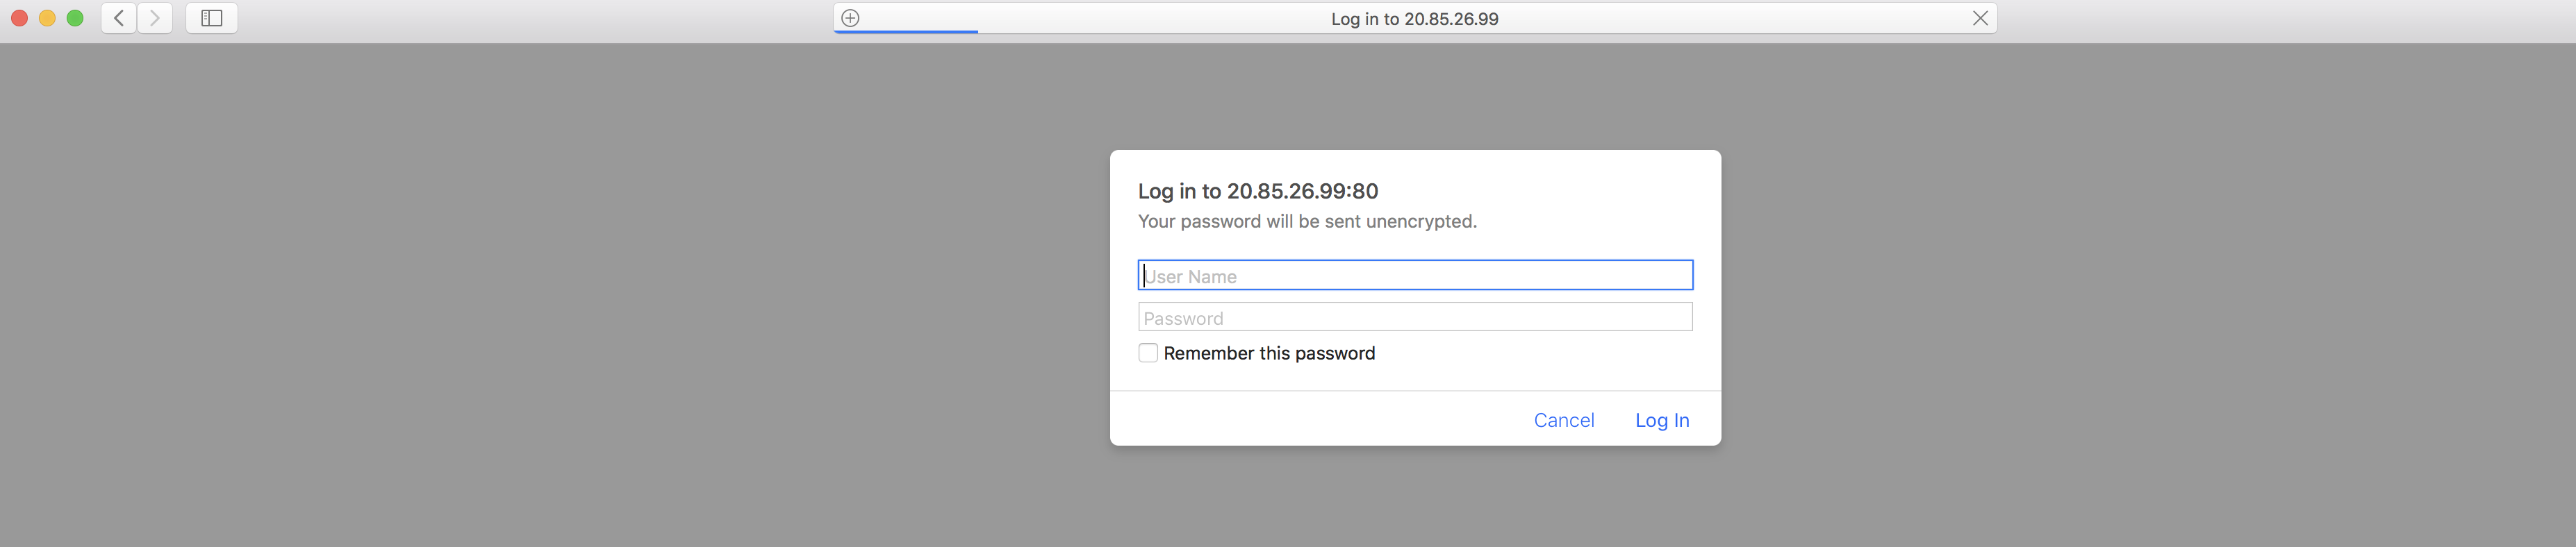

Signing in as usename: jane, password: guest, will allow access to the server.

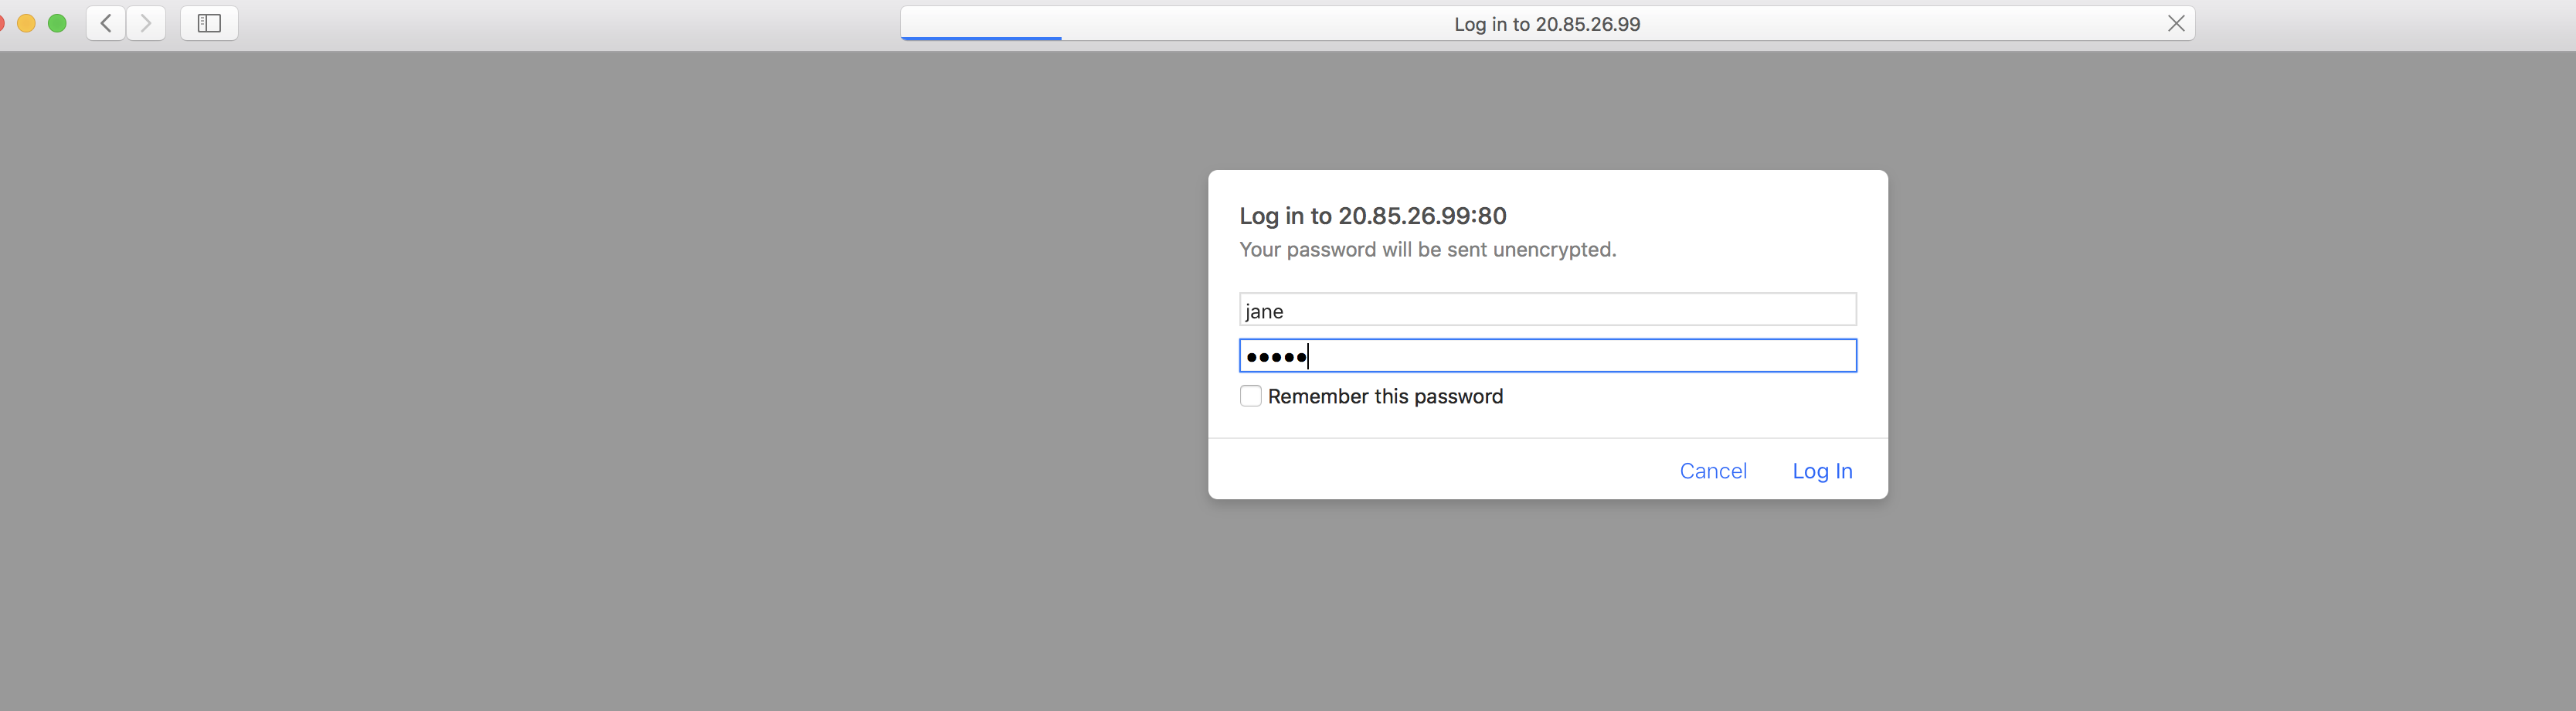

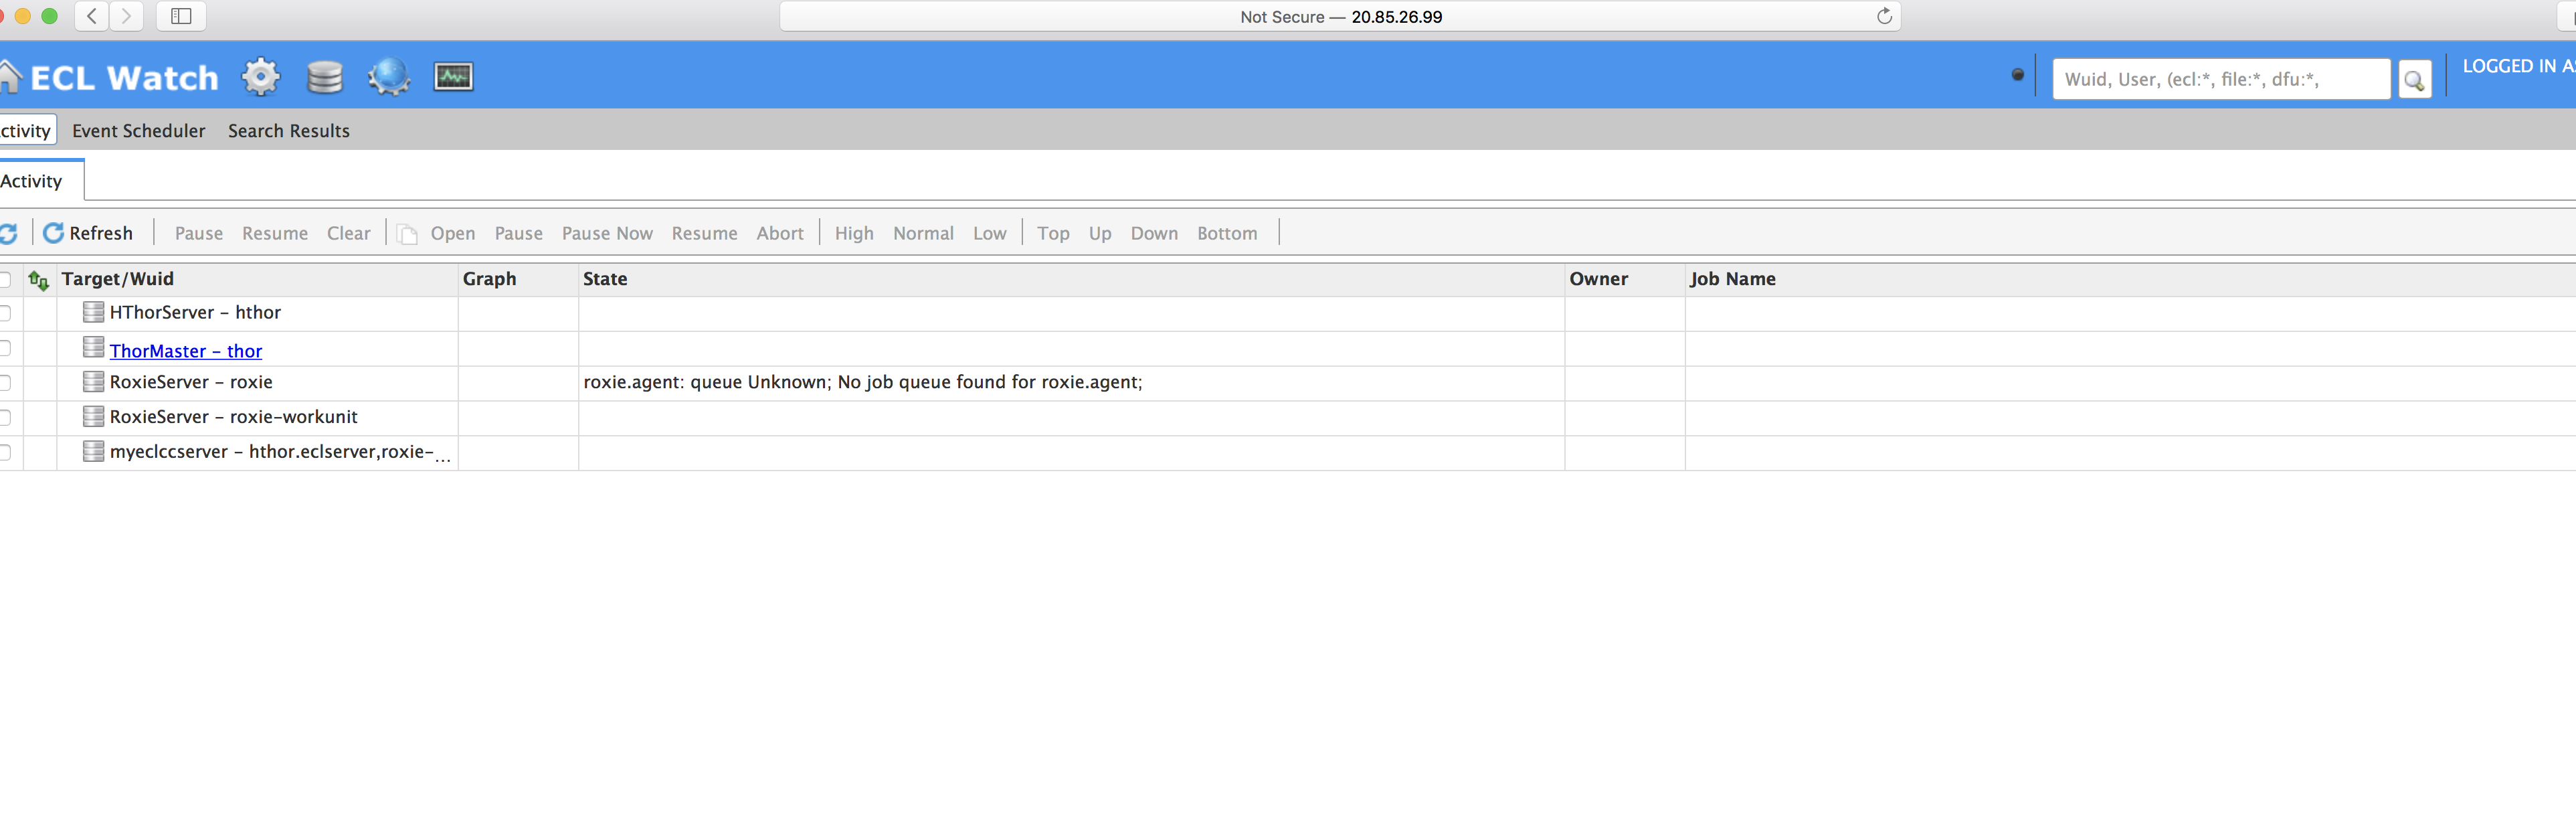

Test the configuration through command line.

The usernames and passwords are:
* ```jane:guest```
* ```john::admin```

First, use the External-IP of the HAProxy controller, without specifying username and password:

In [ ]:
curl -i 20.85.26.99

You should see something like this:

There is an unauthorized error returned, without a username or password specified, access is denied:

In [ ]:
HTTP/1.1 401 Unauthorized
content-length: 112
cache-control: no-cache
content-type: text/html
www-authenticate: Basic realm="localhost"

<html><body><h1>401 Unauthorized</h1>
You need a valid user and password to access this content.

Next, test with specifying username and password, and the output should be similar to the following:

In [ ]:
$ curl -i -u 'john::admin' 20.85.26.99

In [ ]:
HTTP/1.1 200 OK
Content-Type: text/html; charset=UTF-8
Content-Length: 565
Connection: close
Global-Id: G9PhMfQSWvkiMG1Qv9QgQ6

Using ```jane:guest``` user/passwd should have the same output.

## Delete resources
Delete the kuberentes secret:

In [ ]:
kubectl delete secret mypasswd

You should see something like this:

In [ ]:
secret "mypasswd" deleted

Then delete the application created:

In [ ]:
kubectl delete -f eclwatch-auth.yaml

You should see something like this:

In [ ]:
ingress.networking.k8s.io "eclwatch-ingress" deleted